<div style="float:left">
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
     <h1 style="width:600px">Spatial classification of Lewisham based on labour data in 2021 </h1>
     <h3 style="width:600px">Word Count: 1996</h3>
</div>


**Content**
1. Introduction
2. Data 
3. Methodology 
4. Results 
5. Conclusion and Discussion
6. Reference
7. Code

# 1. Introduction

Job placements have fallen sharply in the UK due to the former Covid-19 crisis (Bell and Blanchflower 2020), and the increase in home-based work has led to a significant geographical shift in economic activity (Kaushik and Guleria 2020). And according to the "Learning from the Lewisham COVID-19 Response Hub" report (2020), food poverty increased rapidly compared to the previous period as increasing residents became unemployed during the pandemic, while people with more middle-class professions might be more likely to be furloughed. The collision of some original labour conflicts with new social issues has led to the need for spatial planning and governance of the labour situation in the area.

The application of clustering techniques can provide a more nuanced understanding of the labour market situation in a particular region (Muntaner et al. 2012, Brandas et al. 2016). For example, by identifying regions with similar labour market characteristics, policymakers can target interventions to meet the specific needs of these regions (Martin and Grubb 2001). In addition, by understanding the relationship between different types of data, policymakers can develop more comprehensive policies to address multiple aspects of labour market conditions. In the long run, this can help create a more equitable and sustainable labour market

Therefore, this study aims to provide a spatial classification of the labour market in the Lewisham area through various clustering methods, which is expected to inform the local coordination and response to risk. And the **research questions** mainly include:

**Q1** What is the spatial distribution of the data describing the labour situation?\
**Q2** What are the relationships among the various types of data?\
**Q3** What are the spatial distinctions between clusters?


# 2. Data
## 2.1 Data Source
Minimum space areas in this study are based on the UK Lower Super Output Areas (LSOA) 2021 from [Esri](https://geoportal.statistics.gov.uk/datasets/766da1380a3544c5a7ca9131dfd4acb6_0/explore), which means there are a totally of 175 areas in Lewisham.

The various labour situation LSOA 2021 data is originally from [London Datastore](https://data.london.gov.uk/dataset/2021-census-lsoa-labour-market). Considering the data in the six tables, as well as the characteristics of the study area and the research questions, some data have stronger explanations to the research aim than others. To reduce the bias in the presentation of the labour structure due to differences in local land area and population, local ratio data are used here. In detail:
1. **EconomyActiveRate** = (Economically active residents) / (All usual residents aged 16 or over) * 100\
    Economically active residents include:\
    Economically active: Employee: Full-time \
    Economically active:Employee: Part-time \
    Economically active: Full-time student\
    Economically active: Self-employed with employees: Full-time\
    Economically active: Self-employed with employees: Part-time\
    Economically active: Self-employed without employees: Full-time\
    Economically active: Self-employed without employees: Part-time\
    Economically active: Unemployed
    
2. **InEnploymentRate** = (All usual residents aged 16 and over 16 in employment) / (All usual residents aged 16 or over) * 100
3. **HMAaPRate** = (Higher managerial, administrative and professional occupations) / (All usual residents aged 16 and over 16) * 100
4. **Employ30hOverRate:** = [(Full-time: 31 to 48 hours worked) + (Full-time: 48 or more hours worked)] / (All usual residents aged 16 and over 16 in employment) * 100
5. **WorkMainlyHomeRate:** = (Work mainly at or from home) / (All usual residents aged 16 and over 16 in employment) * 100



## 2.2 Preparation

In [2]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import libpysal
import warnings

## 2.3 Preprocessing
### 2.3.1 Loading Lewisham LSOA Data

The initial UK LSOA 2021 data is the orginal data from [Ersi](https://geoportal.statistics.gov.uk/datasets/766da1380a3544c5a7ca9131dfd4acb6_0/explore), which can be download exactly same from [my Github](https://github.com/YijingZhang1206/CASA0006DSSS/blob/main/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip) as well. To access the Lewisham LSOA data, the dataset can be filtered according to whether the "LSOA21NM" contains "Lewisham".

In [4]:
# Download UK LSOA 2021 data
url = 'https://github.com/YijingZhang1206/CASA0006DSSS/raw/main/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip'
! wget $url
# The ```wget``` command will work for Mac and Linux, but not for Windows

--2023-04-24 15:28:13--  https://github.com/YijingZhang1206/CASA0006DSSS/raw/main/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YijingZhang1206/CASA0006DSSS/main/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip [following]
--2023-04-24 15:28:13--  https://raw.githubusercontent.com/YijingZhang1206/CASA0006DSSS/main/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16770532 (16M) [application/zip]
Saving to

In [5]:
gdf = gpd.read_file("zip://LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025.zip/LSOA_2021_EW_BGC.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  35672 non-null  object  
 1   LSOA21NM  35672 non-null  object  
 2   GlobalID  35672 non-null  object  
 3   geometry  35672 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 1.1+ MB


In [6]:
# Filtering the Lewisham area
gdf.LSOA21NM.str.contains('Lewisham')

0        False
1        False
2        False
3        False
4        False
         ...  
35667    False
35668    False
35669    False
35670    False
35671    False
Name: LSOA21NM, Length: 35672, dtype: bool

In [7]:
gdfl = gdf[gdf.LSOA21NM.str.contains('Lewisham')]
gdfl_normed = gdf.iloc[gdf.LSOA21NM.str.contains('Lewisham').tolist()]
gdfl.shape
# The Lewisham LSOA 2021 data contains 175.

(175, 4)

### 2.3.2 Loading Labour Situation Data

In [8]:
df = pd.read_csv('https://github.com/YijingZhang1206/CASA0006DSSS/raw/main/Labour7.csv', na_values=[':'], low_memory=False)
print(df.shape)
# The London LSOA 2021 data contains 4994.

(4994, 7)


### 2.3.3 Merging Data

In [9]:
ppd = pd.merge(gdfl, df, left_on='LSOA21CD', right_on='LSOA_code', how='inner').reset_index()
ppd.shape

(175, 12)

In [10]:
ppd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   index                                175 non-null    int64   
 1   LSOA21CD                             175 non-null    object  
 2   LSOA21NM                             175 non-null    object  
 3   GlobalID                             175 non-null    object  
 4   geometry                             175 non-null    geometry
 5   LSOA_code                            175 non-null    object  
 6   All usual residents aged 16 or over  175 non-null    int64   
 7   EconomyActiveRate                    175 non-null    float64 
 8   InEnploymentRate                     175 non-null    float64 
 9   HMAaPRate                            175 non-null    float64 
 10  Employ30hOverRate                    175 non-null    float64 
 11  WorkMainlyH

## 2.4 Raw Distribution

Some raw plots and maps are used to present various labour situation distribubtion in Lewisham.

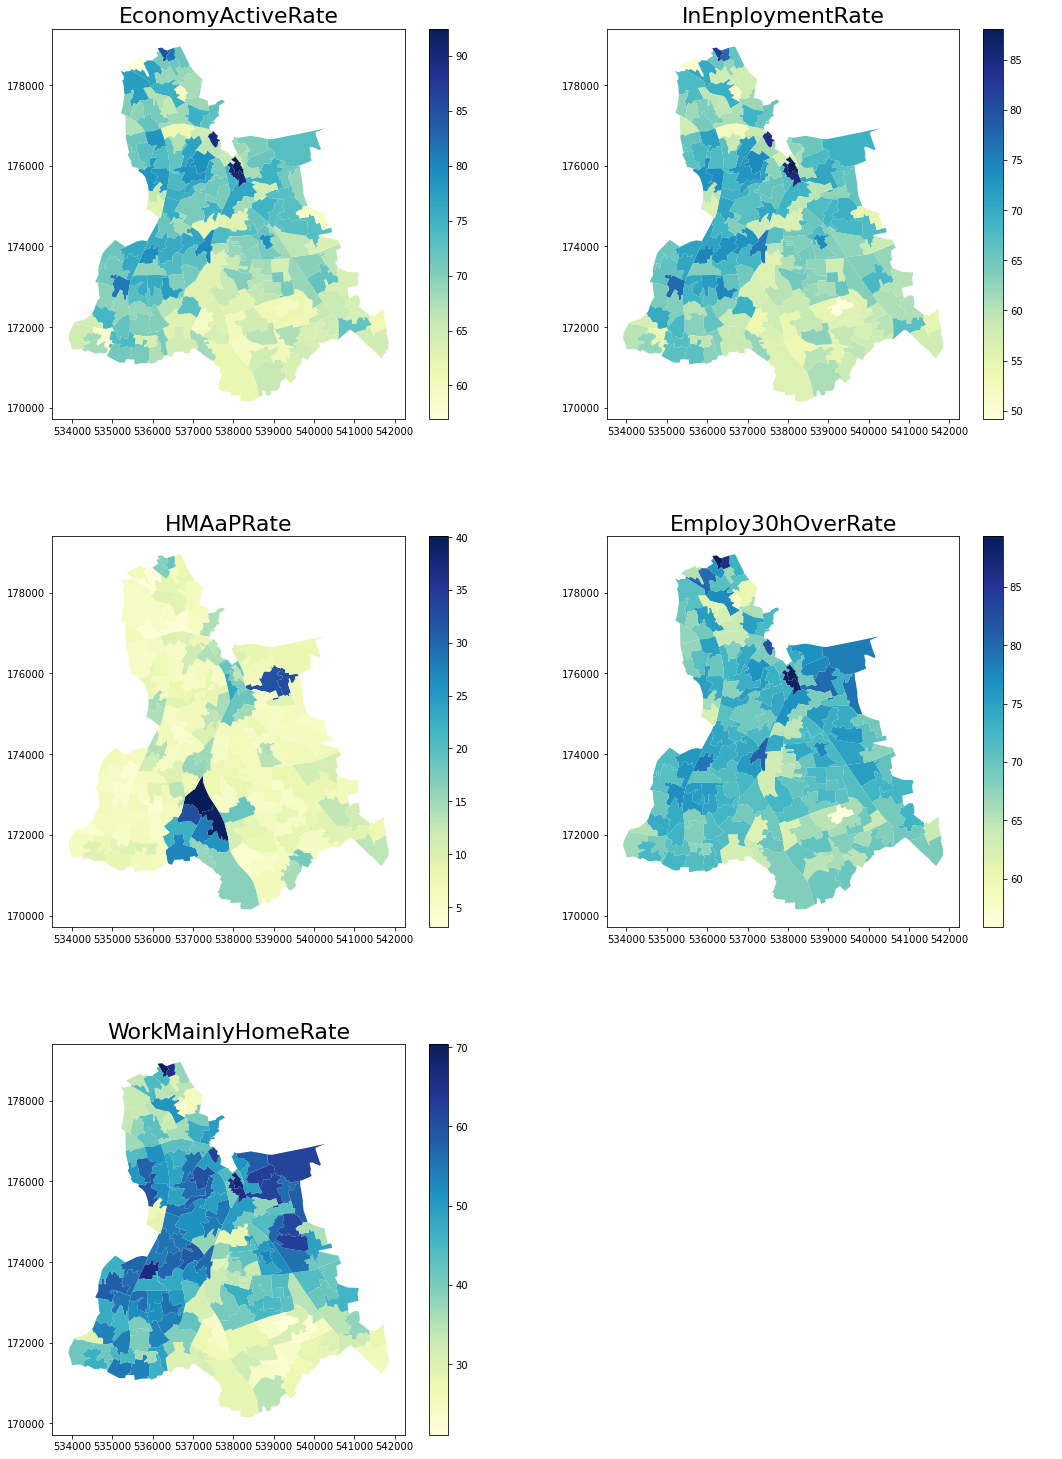

In [11]:
# Title font parameters
tfont = {'fontname': 'DejaVu Sans', 'color': 'black'} 

# 3 rows and 2 columns
f, axarr = plt.subplots(3, 2, figsize=(16, 21)) 

# Plotting maps
ppd.plot(column='EconomyActiveRate', legend=True, cmap='YlGnBu', ax=axarr[0, 0])
axarr[0, 0].set_title("EconomyActiveRate", size=22, **tfont)

ppd.plot(column='InEnploymentRate', legend=True, cmap='YlGnBu', ax=axarr[0, 1])
axarr[0, 1].set_title("InEnploymentRate", size=22, **tfont)

ppd.plot(column='HMAaPRate', legend=True, cmap='YlGnBu', ax=axarr[1, 0])
axarr[1, 0].set_title("HMAaPRate", size=22, **tfont)

ppd.plot(column='Employ30hOverRate', legend=True, cmap='YlGnBu', ax=axarr[1, 1])
axarr[1, 1].set_title("Employ30hOverRate", size=22, **tfont)

ppd.plot(column='WorkMainlyHomeRate', legend=True, cmap='YlGnBu', ax=axarr[2, 0])
axarr[2, 0].set_title("WorkMainlyHomeRate", size=22, **tfont)

# Hiding
axarr[2, 1].axis('off') 

# Adjusting
plt.subplots_adjust(top=0.98, bottom=0.05, left=0.05, right=0.95, hspace=0.3, wspace=0.15)

# Saving the figure
plt.savefig('five_maps.png', dpi=150) # save the figure

## 2.5 Selection and Standardisation


The ```RobustScaler``` class from the ```sklearn``` package for standardising the dataset is used in this study.It removes the median and scales the data according to the quantile range (defaults to between 25 and 75 quantile).

In [12]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [13]:
ppd.head()

,index,LSOA21CD,LSOA21NM,GlobalID,geometry,LSOA_code,All usual residents aged 16 or over,EconomyActiveRate,InEnploymentRate,HMAaPRate,Employ30hOverRate,WorkMainlyHomeRate
0,0,E01003189,Lewisham 034A,b6ba15fc-4638-4be9-89d8-933d63b0d390,"POLYGON ((537627.388 171966.710, 537672.224 17...",E01003189,1326,64.027,56.486,25.650,69.987,25.569
1,1,E01003190,Lewisham 034B,8620a3f5-394e-4ee1-ad6f-5cedf5eacc8c,"POLYGON ((536762.977 172026.305, 536751.439 17...",E01003190,1716,64.627,58.508,27.085,62.702,30.251
2,2,E01003191,Lewisham 034C,76d11ced-fb96-490f-b395-1eb6d05f43a9,"POLYGON ((537079.289 171863.491, 537091.383 17...",E01003191,1294,68.238,62.287,15.559,63.827,30.988
3,3,E01003192,Lewisham 034D,aa858ea2-10bc-4de3-8e36-d7c2b96ecaa8,"POLYGON ((537479.991 171676.902, 537586.569 17...",E01003192,1394,61.908,56.241,16.264,68.147,28.645
4,4,E01003193,Lewisham 029A,e827abc2-9668-4efd-b383-9ea345689e68,"POLYGON ((536609.078 172387.938, 536638.293 17...",E01003193,1384,63.078,58.526,22.230,71.429,39.435


According to the five maps, 'EconomyActiveRate' and 'InEnploymentRate'shows similar raw distribution, and they shows a certain linear relationship based on the first scatter plot. In addition, because of the current social context, we expect to focus more on the economic contribution of the local labour market, so we exclude 'InEnploymentRate'. Meanwhile,although the “HMAaPRate ” is kind of extreme, i.e.most of the area is less than 10, it would be still retained in order to better represent the impact of 'high' labour on the local division of labour.

<AxesSubplot:xlabel='EconomyActiveRate', ylabel='InEnploymentRate'>

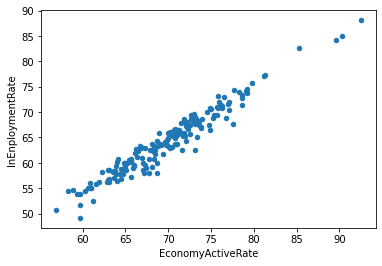

In [14]:
ppd.plot.scatter(x= 'EconomyActiveRate', y='InEnploymentRate', figsize=(6, 4))

Therefore, 4 variables are focused here: EconomyActiveRate, HMAaPRate， Employ30hOverRate, and WorkMainlyHomeRate, while ```LSOA21CD``` workes as the index of 
LSOAs.

In [15]:
raw = ppd[['LSOA21CD','EconomyActiveRate','HMAaPRate', 'Employ30hOverRate','WorkMainlyHomeRate']].set_index('LSOA21CD').copy()
raw.head()

,EconomyActiveRate,HMAaPRate,Employ30hOverRate,WorkMainlyHomeRate
LSOA21CD,,,,
E01003189,64.027,25.650,69.987,25.569
E01003190,64.627,27.085,62.702,30.251
E01003191,68.238,15.559,63.827,30.988
E01003192,61.908,16.264,68.147,28.645
E01003193,63.078,22.230,71.429,39.435


In [16]:
# Standardisation
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of EconomyActiveRate is [-0.9321600181968099, 1.5952773591879668]
The range of HMAaPRate is [-0.3630150466069097, 2.9425867282128357]
The range of Employ30hOverRate is [-1.3360009763922314, 1.5826271925236253]
The range of WorkMainlyHomeRate is [-0.7766240395465048, 0.879318682499597]


,EconomyActiveRate,HMAaPRate,Employ30hOverRate,WorkMainlyHomeRate
LSOA21CD,,,,
E01003189,-0.427199,1.653427,-0.103393,-0.625537
E01003190,-0.384550,1.781797,-0.738484,-0.468305
E01003191,-0.127875,0.750720,-0.640409,-0.443555
E01003192,-0.577820,0.813787,-0.263800,-0.522238
E01003193,-0.494655,1.347485,0.022318,-0.159885


Then, the main distribution of variables and the interrelationships among them can be represented.

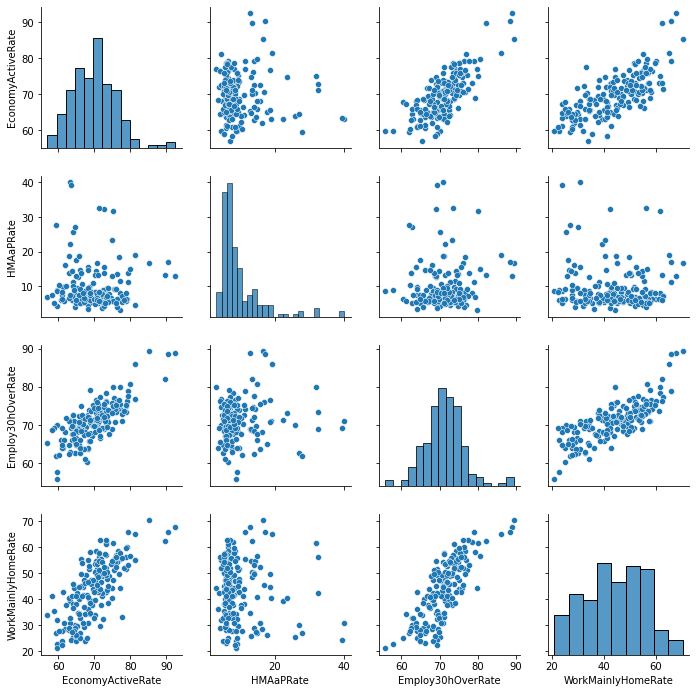

In [17]:
variables = ['EconomyActiveRate','HMAaPRate','Employ30hOverRate', 'WorkMainlyHomeRate']
sns.pairplot(ppd[variables])

# Adjusting
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.2, wspace=0.2)

# Saving the plot
plt.savefig('two_by_two_scatter.png', dpi=150)

# 3. Method
## 3.1 Kmeans Clustering
The K-means clustering algorithm is a simple unsupervised algorithm for quick predictive grouping from unlabelled datasets (Sinaga and Yang 2020). The prediction is based on the number of centroids present (K) and the nearest mean, a measure of Euclidean distance between given observations.

## 3.2 Hierarchical Clustering
Hierarchical clustering approaches dpredict subgroups in the data by finding the distance between every data point and its nearest neighbours, and then linking the most nearby neighbours. The algorithm predicts subgroups using its calculated distance metric. It relies on a dendrogram visualisation of clustering.

## 3.3 Max-p Regionalisation
Because the clusters generated by Kmeans or Hierarchical clustering methods are not spatially contiguous, the max-p method works as a further attempt for this study. It aims to generate a maximum number of clusters conditioning that each cluster is spatially contiguous. And the sum of a variable of each cluster is above a predefined threshold value (Sindhu 2018).

## 3.4 Functions
A function for mapping the clustering results:

In [18]:
def mapping_clusters(labels_cluster):
    ppd['cluster_nm'] = labels_cluster
    ppd.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

A function for the radar plot of the cluster centroids:

In [19]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

# 4. Results
## 4.1 Kmeans Clustering

In [20]:
# Preparation
from sklearn.cluster import KMeans

First, the Elbow method are used to choose the k value. This is to identify the value of k where the distortion begins to decrease most rapidly.

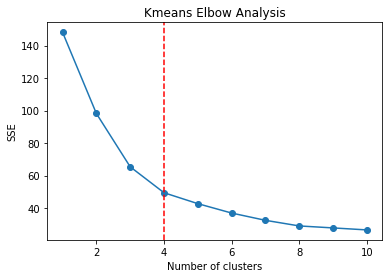

<Figure size 288x216 with 0 Axes>

In [21]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.title('Kmeans Elbow Analysis')
plt.axvline(x=4, linestyle='--', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.figure(figsize=(4,3))
plt.show()

From the SSE plot, 4 might be the optimal k value. 

In [22]:
k_cluster = 4
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
x_transformed = kmeans_method.fit_transform(normed)
print(normed.shape)
print(normed.columns)
# print(kmeans_method.labels_)
print(x_transformed.shape)

for centroid in kmeans_method.cluster_centers_:
    print(np.linalg.norm(np.array(normed)[0] - centroid))
print(x_transformed[0])

(175, 4)
Index(['EconomyActiveRate', 'HMAaPRate', 'Employ30hOverRate',
       'WorkMainlyHomeRate'],
      dtype='object')
(175, 4)
2.3758269226001705
1.6013888117094273
1.9535581912018616
0.5347734348310843
[2.37582692 1.60138881 1.95355819 0.53477343]


In [23]:
k_cluster = 4
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=4, random_state=1)

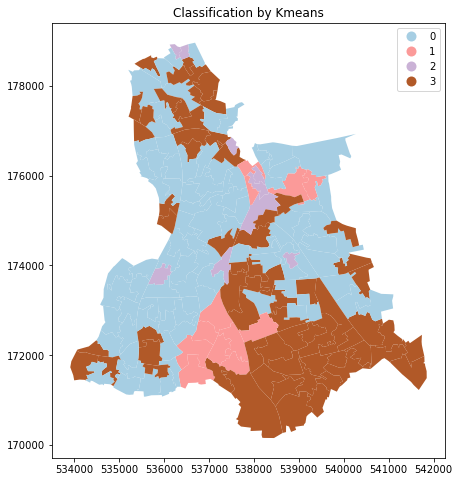

In [24]:
# mapping
mapping_clusters(kmeans_method.labels_);
plt.title('Classification by Kmeans')
plt.show()

Inevitably, K-Means involves randomness. However, in this example, the outputs are essentially the same.

The map above represents the geographical distribution of the four categories created by the K-means algorithm. It shows a strong spatial structure in the distribution of the colours: group0 is mostly found in the periphery East and West, while group1 is concentrated in the south mostly. Group3 is the most dispersed, mostly in the southeast.

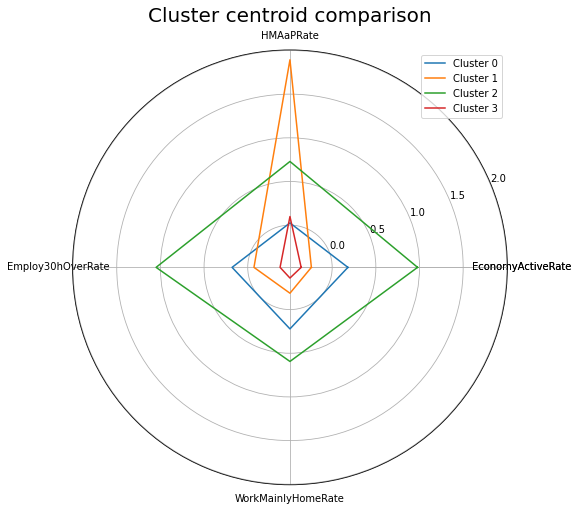

In [25]:
# visualise the cluster centroid using the radar plot
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In addition, K-Means works well for linearly separable clusters, but not the case in sorgplex geospatial data K-Means clustering. So we show them as well, and  half of the diagram demonstrates the feasibility of classification. The others were not sufficiently divided into four categories, which may also explain the presence of similar classification-type cases in the radar plots.

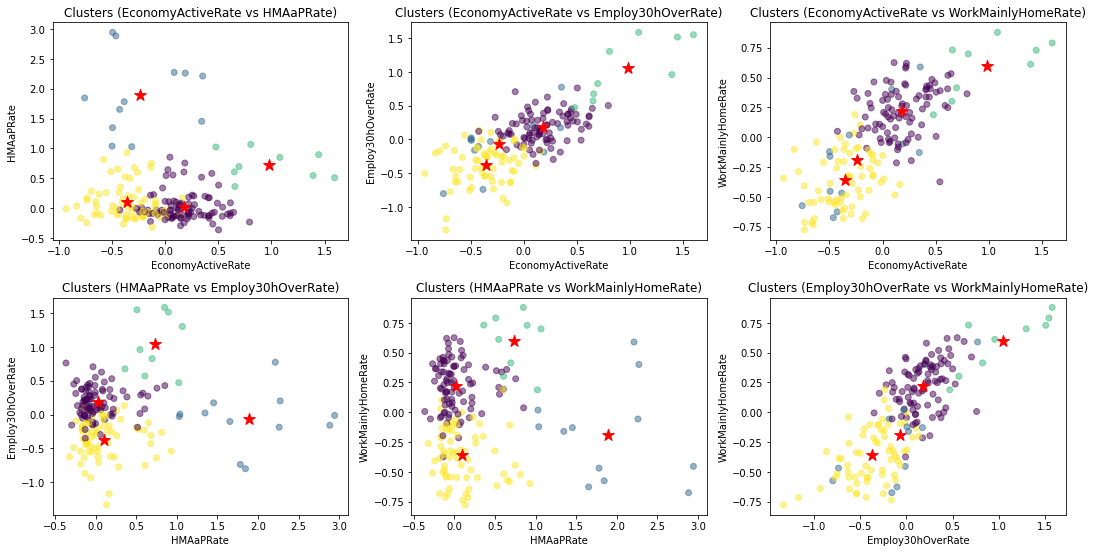

In [26]:
import itertools

# get combinations of features for plotting
feature_combinations = list(itertools.combinations(normed.columns, 2))

# create subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

# plot each combination of features with cluster labels
for i, (x_feature, y_feature) in enumerate(feature_combinations):
    ax = axes[i]
    ax.scatter(normed[x_feature], normed[y_feature], c=kmeans_method.labels_, alpha=0.5)
    ax.scatter(kmeans_method.cluster_centers_[:, normed.columns.get_loc(x_feature)],
               kmeans_method.cluster_centers_[:, normed.columns.get_loc(y_feature)],
               marker='*', s=150, color='r')
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.set_title(f'Clusters ({x_feature} vs {y_feature})')

# remove unused subplots
for ax in axes[len(feature_combinations):]:
    ax.remove()

plt.tight_layout()
plt.show()

## 4.3 Hierarchical Clustering

The Agglomerative Clustering will be tested for the dataset. The study generates and plots the dendrogram from the clustering process. This shows the hierarchy of the clusters.

In [27]:
def plot_dendrogram(model, **kwargs):
    # create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

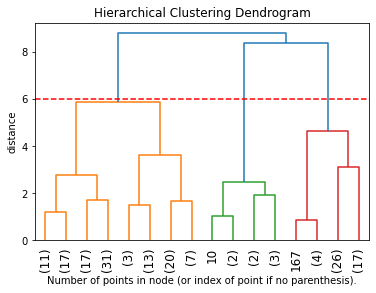

In [28]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normed)
ax = plt.gca()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
plt.hlines(6, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.show()

This dendrogram shows that there is a big gap between the distance of 6 to the next merge. This means that three clusters are appropriate here.

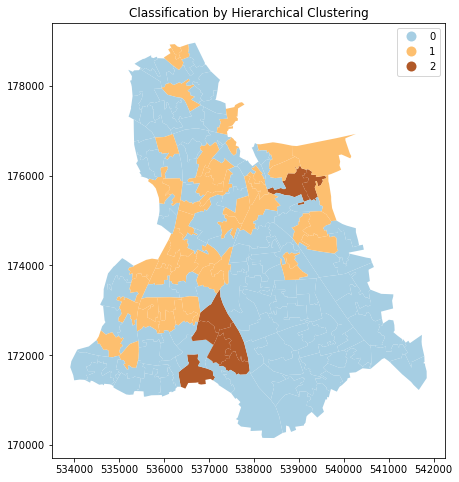

In [29]:
# mapping
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=3).fit(normed)
mapping_clusters(agg_cluster.labels_)
plt.title('Classification by Hierarchical Clustering')
plt.show()

In [30]:
pd.Series(agg_cluster.labels_).value_counts()

0    119
1     48
2      8
dtype: int64

The map shows the geographical distribution of the three categories created by Hierarchical Clustering. Most of it is occupied by group0, while Group1 is more dispersed and located in the north-west of the region. Group2 is very similar to Group1 in the previous figure from kmeans. This is most likely due to the particular distribution of higher managerial, administrative and professional occupations.

## 4.4 Max-p Regionalisation

In [31]:
#Preparation
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")
RANDOM_SEED = 123456

This method aims to cluster the LSOAs into the maximum number of regions. 

In [32]:
# define the variables in the dataframe that will be used to measure regional homogeneity:
attrs_name = raw.columns.values.tolist()
attrs_name

['EconomyActiveRate', 'HMAaPRate', 'Employ30hOverRate', 'WorkMainlyHomeRate']

In [33]:
# specify a number of parameters that will serve as input to the max-p model. 
# A spatial weights object expresses the spatial connectivity of the LSOAs
w = libpysal.weights.Queen.from_dataframe(ppd)

In [34]:
# specify the minimum number of LSOAs contained by each region (threshold):
threshold = 0.2 * raw.shape[0]
print(threshold)
raw_copy = raw.copy()
raw_copy["count"] = 1
threshold_name = "count"

35.0


Then, the model can be instantiated and solved. 

In [35]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(raw_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 183 ms, sys: 12 ms, total: 194 ms
Wall time: 192 ms


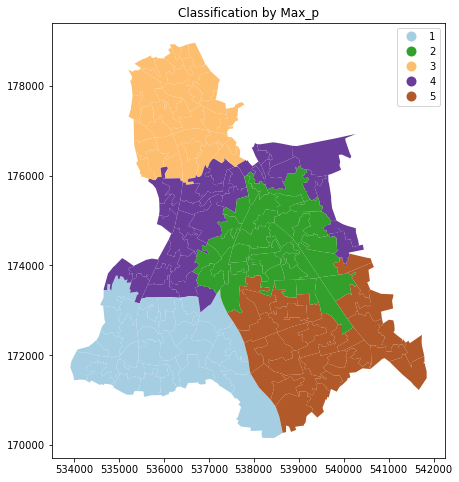

In [36]:
# mapping
ppd['cluster_max_p'] = model.labels_
ppd.plot(column='cluster_max_p', categorical=True, legend=True, figsize=(12,8), cmap='Paired');
plt.title('Classification by Max_p')
plt.show()

This map differs significantly from the first two due to the differences in principle among methods. The spatial continuity of the same type makes this spatial classification more rational and effective. Of the five groupings: Group2 is located in the centre, Group3 in the north-west region, Group1 in the south-west region and Group5 in the south-east region, which are four classifications that are not similar to the previous ones. The Group4 region is similar to Group0 from the Kmeans map, and Group1 from the Hierarchical Clustering map.

# 5. Conclusion and Discussion

Overall, within the study area of nearly 200 blocks, Lewisham can be divided into 3-5 clusters by different methods based on data related to the labour situation. Although there are many spatial differences between the three divisions, the similarities are indicative of some of the characteristics and issues of the local economy and society.

In terms of the **answer to the research questions**:\
**A1:** Based on the spatial distribution characteristics of the various types of labour data in 2.4, their levels vary across regions. In the West and North East, the levels of economically active residents’ rate, employed residents’ rate, employed 30h over residents’ rate and work mainly at or from home residents’ rate are all higher. Their highest values occur at LSOA Lewisham 040B and 040C. Combined with the [OpenStreetMap](https://www.openstreetmap.org/node/27365305#map=14/51.4623/-0.0088), the local area contains the Lewisham rail and tube transport centres, as well as the Lewisham Shopping Centre. They continued to provide a more intensive demand for employment during and after the epidemic due to the need to live. However, the proportion of citizens in higher managerial, administrative and professional occupations is relatively average in the West and Northeast. Instead, they are clustered in a triangular area in the south-central part, and in a small part in the south-east. And the level of full-time 30+ hours in both regions is not low. According to the [Lewisham Dynamicmaps](https://lbl.dynamicmaps.co.uk/MapThatWeb/Default.aspx), this can be partly because of local schools and Lewisham Town Hall, etc.
    
    
**A2:** According to the plots from 2.5, except HMAaPRate, there is some direct positive correlation for all labour data, although not particularly significant. The extremely clear linear relationship between the economically active residents' rate and the employed residents' rate is not surprising, as the proportion of non-working but economically active people is still a minority.
    
    
**A3:** Although in the maps produced by the first two clustering methods each class is not exactly spatially contiguous, their classification is still worthy of reference. They both classify regions with high levels of HMAaPRate into separate groups.\
In figure3, **group4** is more similar to figure1-group0, and figure2-group1 because of regional distribution. This suggests that the structure of the labour characteristics in Lewisham Central West and Central East are similar. Combined with the Raw Distribution, the region has higher levels of EconomyActiveRate, Employ30hOverRate, and WorkMainlyHomeRate. If this group were to be named or profiled: the region has a higher proportion of residents working full-time and more likely to be able to work from home during the epidemic, possibly resulting in a more stable economic situation.\
Figure3-**group1** is similar to figure3-group4 when compared to the Raw Distribution. However, it contains areas with high levels of HMAaPRate that were classified separately in both of the previous two methods. This is likely to take into account the effects of classification following spatial continuity.\
In addition, figure3-**group5** is also more similar to figure1-group3 because of its distribution. This region is likely to have a unique labour structure. Combined with the Raw Distribution, the economically active residents' rate is generally low, but the proportion of citizens working full-time for more than 30 hours is not low, and a small number of people work mainly at or from home. If this group is named or profiled, it is likely that workers in the area are mainly engaged in full-time work that still requires travel to areas such as the city centre, and that the proportion of them who are economically active is low. This may also be due to the high proportion of retired, recreational residents due to the large amount of green space in the area. The area may need support in terms of transport, medical care and provision of essential goods when facing epidemic or other risks.\
Figure3-**group2** compares with the raw distribution chart and shows that the region has a moderate level of EconomyActiveRate, Employ30hOverRate, and WorkMainlyHomeRate. Figure3-**group3** is only higher in EconomyActiveRate, compared to group2. This is probably due to the fact that group3 is closer to the city centre and therefore has a higher Economy Active residents' rate.

As for the **Limitation** in this study, \
**a.** it is undeniable that we only attempt here to classify labour data according to four categories in order to better explain current social issues. However, some other labour data such as mode of commuting to work, although in 2021 fewer residents commute to work by transport etc. due to the home factor, this and other factors not taken into account may have an impact on the spatial classification when applying the method to other regions or times.This need to be considered for the next step analysis.\
**b.** Limitations of the model themselves. These may include spatial data processing and center of mass location issues, etc.
**c.** Current available LSOA socio-economic data for 2021 is limited, and if available in the future to include factors such as income levels, it may be possible to better classify regions.


# Reference 
Bell, D. N., & Blanchflower, D. G. (2020) US and UK labour markets before and during the Covid-19 crash. *National Institute Economic Review*, 252, R52-R69.

Brandas, C., Panzaru, C., & Filip, F. G. (2016) Data driven decision support systems: an application case in labour market analysis. *Romanian Journal of Information Science and Technology*, 19(1-2), 65-77.

Ersi. (2022) LSOA (Dec 2021) Boundaries Generalised Clipped EW (BGC). Available at: https://geoportal.statistics.gov.uk/datasets/766da1380a3544c5a7ca9131dfd4acb6_0/explore (Accessed: 20 April 2023)

Hamnett, C. (2015) The changing occupational class composition of London. *City*, 19(2-3), 239-246.

Kaushik, M., & Guleria, N. (2020) The impact of pandemic COVID-19 in workplace. *European Journal of Business and Management*, 12(15), 1-10.

LondonDatastore. (2023) 2021 census lsoa labour market. Available at:https://data.london.gov.uk/dataset/2021-census-lsoa-labour-market (Accessed: 20 April 2023)

Martin, J. P., & Grubb, D. (2001) What Works and for Whom: A Review of OECD Countries' experiences with active labour market policies. *Swedish economic policy review*, 8(2), 9-56.

Muntaner, C., Chung, H., Benach, J., & Ng, E. (2012) Hierarchical cluster analysis of labour market regulations and population health: a taxonomy of low-and middle-income countries. *BMC Public Health*, 12(1), 1-15.

Shukra, K. (2020) *Learning from the Lewisham COVID-19 Response Hub*.

Sinaga, K. P., & Yang, M. S. (2020) Unsupervised K-means clustering algorithm. *IEEE access*, 8, 80716-80727.

Sindhu, V. (2018) *Exploring Parallel Efficiency and Synergy for Max-P Region Problem Using Python*.

# Code 
Code is hosted [here](https://github.com/YijingZhang1206/CASA0006DSSS/blob/main/LewishamLabourClassification.ipynb)